In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
from tqdm import tqdm

import xspec

import sys
sys.path.append('../')
from uvot import filter_colors, filter_ref, filter_W_eff

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [12]:
filter_lo = {}
filter_hi = {}

for f in filter_ref.keys():
    ref  = filter_ref[f]
    W_eff = filter_W_eff[f]
    hi   = ref + 0.5*W_eff
    lo   = ref - 0.5*W_eff
    filter_lo[f] = lo
    filter_hi[f] = hi
    


def T_ph(m_dot, m):
    f_col = 1.7
    zeta = 1
    beta = 1
    e_w  = 0.95
    
    #m = 1
    return 0.8 * f_col * (zeta * beta / e_w)**0.5 * m**-0.25 * m_dot**-0.75

def keV_to_AA(keV):
    AA = 10*1239.8 / (1000 * keV)
    return AA

def AA_to_keV(AA):
    keV = keV_to_AA(AA) # it's just the inverse
    return keV

/tmp/ipykernel_31247/3181110778.py:24: RuntimeWarning: divide by zero encountered in true_divide
  AA = 10*1239.8 / (1000 * keV)


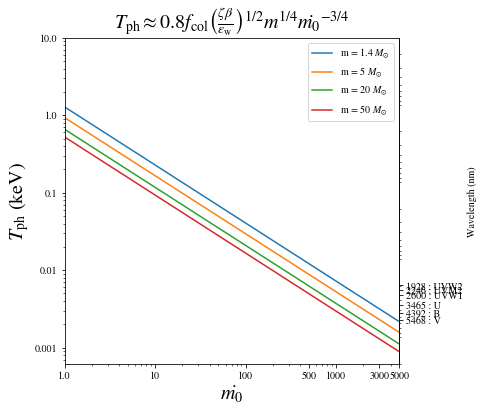

In [13]:

m_lo, m_hi, m_n = 1,5000,100
mdots = np.linspace(m_lo, m_hi, m_n)


fig, ax = plt.subplots(facecolor='white', figsize=(6,6))
ax.loglog(mdots, T_ph(mdots, 1.4), label=r'm = 1.4 $M_{\odot}$')
ax.loglog(mdots, T_ph(mdots, 5), label=r'm = 5 $M_{\odot}$')
ax.loglog(mdots, T_ph(mdots, 20), label=r'm = 20 $M_{\odot}$')
ax.loglog(mdots, T_ph(mdots, 50), label=r'm = 50 $M_{\odot}$')

xticks = [1.0,10,100,500,1000, 3000,5000]
yticks = [10.0, 1.0, 0.1, 0.01, 0.001]


secax = ax.secondary_yaxis('right', functions=(keV_to_AA, keV_to_AA))
secax.set_ylabel('Wavelength (nm)')
secax.set_yticks(ticks=[1,1928,2246,2600,3465,4392,5468], labels=[1,'1928 : UVW2', '2246 : UVM2', '2600 : UVW1', '3465 : U', '4392 : B', '5468 : V',])

ax.set_title(r'$T_{\mathrm{ph}} \approx 0.8 f_{\mathrm{col}} \left(\frac{\zeta\beta}{\epsilon_{\mathrm{w}}}\right)^{1/2} m^{1/4} \dot{m_{0}}^{-3/4}$', size=20)
ax.set_xticks(ticks=xticks, labels=xticks)
ax.set_yticks(ticks=yticks, labels=yticks)
ax.set_xlim(m_lo,m_hi)
plt.xlabel(r'$\dot{m_{0}}$', size=20)
plt.ylabel(r'$T_{\mathrm{ph}}$ (keV)', size=20)
ax.legend()


T_keV = 0.01
T_K = 1.159e7 * T_keV
T_K = T_K * u.K
bb = BlackBody(temperature=T_K)
wav = np.arange(100, 6000) * u.AA
flux = bb(wav)



100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.51it/s]


AttributeError: 'numpy.float64' object has no attribute 'unit'

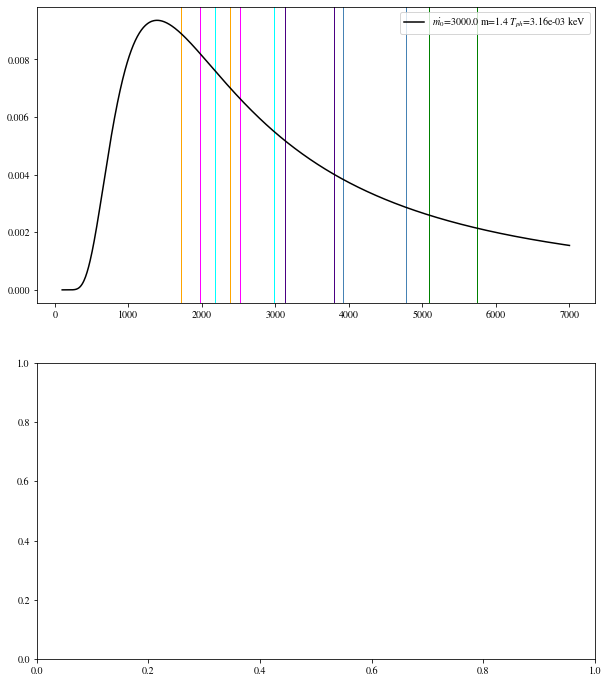

In [14]:
# Temperature is set by the spherization radius
mdot = 3000
m = 1.4

mdots = np.linspace(1,3000, 10)

# Initialize arrays
filter_flux = {}
for f in filter_ref.keys():
    filter_flux[f] = []


for mdot in tqdm(mdots):
    T = T_ph(m_dot=mdot, m=m)

    # Set up the blackbody
    T_keV = T
    T_K = 1.159e7 * T_keV
    T_K = T_K * u.K
    bb = BlackBody(temperature=T_K)

    # Evaluate the full blackbody curve
    wav_full = np.linspace(100, 7000, 1000) * u.AA
    flux_full = bb(wav_full)

    # Integrate the flux for the filters
    #filter_flux = {}
    for f in filter_ref.keys():   
        lo = filter_lo[f]
        hi = filter_hi[f]
        wav = np.linspace(lo, hi, 1000) * u.AA
        flux = bb(wav)
        int_flux = np.trapz(x=wav, y=flux)
        filter_flux[f].append(int_flux.value * mdot**2)

    

###########    
# Plotting    
###########
fig, ax = plt.subplots(2, 1, facecolor='white', figsize=(10,12))

# Plot filter regions
for f in filter_ref.keys():
    ax[0].axvline(filter_lo[f], color=filter_colors[f],lw=1.0)#, label=f'{f} Flux = {filter_flux[f]:.2f}')
    ax[0].axvline(filter_hi[f], color=filter_colors[f],lw=1.0)

# Plot blackbody
ax[0].plot(wav_full, flux_full, label=rf'$\dot{{m_0}}$={mdot} m={m} $T_{{ph}}$={T_keV:.2e} keV', color='black')

# Axis settings
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].legend()



for f in filter_flux.keys():
    units = filter_flux[f][0].unit
    ref = filter_ref[f]
    flux = filter_flux[f]
    ax[1].scatter(ref, flux, color=filter_colors[f], label=f)

ax[1].set_xlabel('wavelength ($\AA$)')
ax[1].set_ylabel(f'Integrated flux ({units})')
ax[1].set_ylim(ymin=0)
ax[1].legend()
plt.show()

In [ ]:
plt.figure(facecolor='white', figsize=(6,6))
for f in filter_flux.keys():
    flux = filter_flux[f]
    plt.plot(mdots, flux, color=filter_colors[f], label=f)

plt.xlabel('mdot')
plt.ylabel('Flux')
plt.ylim(0,100)
plt.legend()
plt.show()

In [ ]:
mdots = np.linspace(100,3000, 10)
plt.figure(facecolor='white', figsize=(10,10))

for mdot in tqdm(mdots):
    T = T_ph(m_dot=mdot, m=m)

    # Set up the blackbody
    T_keV = T
    T_K = 1.159e7 * T_keV
    T_K = T_K * u.K
    bb = BlackBody(temperature=T_K)

    # Evaluate the full blackbody curve
    wav_full = np.linspace(10, 3000, 1000) * u.AA
    flux_full = bb(wav_full)
    plt.plot(wav_full, flux_full, label=f'mdot={mdot:.2f} \tT={T_K:.2e}')

# Plot filter regions
plt.xlabel('wavelength $\AA$')
plt.ylabel('flux')
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01, 100)
#plt.xlim(100,3000)
plt.legend(loc='upper right')

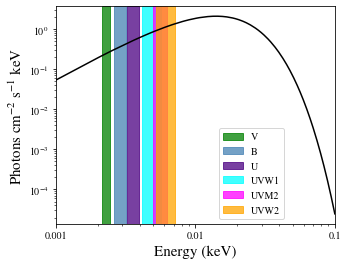

In [15]:
energies = np.logspace(-3, -1, 5000)
xspec.AllModels.setEnergies("0.001 0.1 5000 log")
T = 0.005
model = xspec.Model('bbody', setPars={1:T, 2:1})
flux = model.values(0)


plt.figure(figsize=(5,4), facecolor='white')
for f in ['V','B','U','UVW1','UVM2','UVW2']:
    lo = filter_lo[f]
    hi = filter_hi[f]
    
    hi_kev = keV_to_AA(lo)
    lo_kev = keV_to_AA(hi)
    
    plt.axvspan(lo_kev, hi_kev, color=filter_colors[f],lw=1.0, label=f, alpha=0.75)
    
plt.loglog(energies, flux, color='black')
xticks = [0.001,0.01, 0.1]
plt.xticks(ticks=xticks, labels=xticks)
plt.xlim(0.001, 0.1)
plt.xlabel('Energy (keV)', size=15)
plt.ylabel('Photons $\mathrm{cm^{-2} \ s^{-1} \ keV}$', size=15) 
plt.legend(loc='lower center', bbox_to_anchor=(0.7,0.0))
plt.savefig('../figures/bbody_UVOT.pdf')
plt.savefig('../figures/bbody_UVOT.png')


In [16]:
# Temperature is set by the spherization radius
mdot = 3000
m = 1.4

mdots = np.linspace(1,50000, 4000)

# Initialize arrays
filter_flux = {}
for f in filter_ref.keys():
    filter_flux[f] = []


# Initialize arrays
filter_flux = {}
for f in filter_ref.keys():
    filter_flux[f] = []

xspec.AllModels.setEnergies("0.001 1. 5000 log")
    
for mdot in tqdm(mdots):
    
    T = T_ph(m_dot=mdot, m=m)
    model = xspec.Model('bbody', setPars={1:T, 2:1})
    
    # Integrate the flux for the filters
    #filter_flux = {}
    for f in ['V','B','U','UVW1','UVM2','UVW2']:   
        lo = filter_lo[f]
        hi = filter_hi[f]
        
        hi_kev = keV_to_AA(lo)
        lo_kev = keV_to_AA(hi)

        calc_flux_arg = f"{lo_kev:.4f} {hi_kev:.4f}"
        xspec.AllModels.calcFlux(calc_flux_arg)
        flux_vals = xspec.AllModels(1).flux
        flux = flux_vals[0] # ergs/cm^2/s
        nphotons = flux_vals[3]
        filter_flux[f].append(flux)

        
        

100%|█████████████████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1012.74it/s]


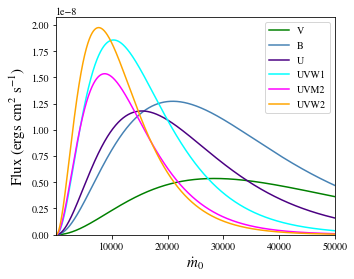

In [18]:
plt.figure(facecolor='white', figsize=(5,4))
for f in ['V','B','U','UVW1','UVM2','UVW2']:
    flux = filter_flux[f]
    plt.plot(mdots, flux, color=filter_colors[f], label=f)
#plt.xlim(4000,15000)
plt.xlabel('$\dot{m}_0$', size=15)
plt.ylabel('Flux ($\mathrm{ergs \ cm^2 \ s^{-1}}$)', size=15)
plt.ylim(0)
plt.xlim(1,50000)
plt.legend()
plt.savefig('../figures/UVOT_mdot_peak.png', bbox_inches='tight')
plt.savefig('../figures/UVOT_mdot_peak.pdf', bbox_inches='tight')

plt.show()